# <center> Финальное задание </center>
## <center> Предсказание пола клиента по транзакциям</center>

## Описание задачи 
#### Ваше задание - предсказать пол клиента, основываясь на его транзакционных исторических данных. Выполнение финального задания - это маленький шаг в большую Data Science-всесенную, поэтому отнеситесь к нему максимально серьёзно :)
#### В роли метрики выступает [ROC AUC](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/), который и нужно будет оптимизировать.

In [1]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install joblib

Defaulting to user installation because normal site-packages is not writeable


In [25]:
import pandas as pd
import numpy as np
import xgboost as xgb
import re
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import joblib

from tqdm._tqdm_notebook import tqdm_notebook

In [115]:
PATH_DATA = './data'
MODEL_PATH = "model.pkl"

In [116]:
# Считываем данные
tr_mcc_codes = pd.read_csv(os.path.join(PATH_DATA, 'mcc_codes.csv'), sep=';', index_col='mcc_code')
tr_types = pd.read_csv(os.path.join(PATH_DATA, 'trans_types.csv'), sep=';', index_col='trans_type')

transactions = pd.read_csv(os.path.join(PATH_DATA, 'transactions.csv'), index_col='client_id')
gender_train = pd.read_csv(os.path.join(PATH_DATA, 'train.csv'), index_col='client_id')
gender_test = pd.read_csv(os.path.join(PATH_DATA, 'test.csv'), index_col='client_id')
transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')

In [117]:
# Функции, которыми можно пользоваться для построения классификатора, 
# оценки его результатов и построение прогноза для тестовой части пользователей

# Cross-validation score (среднее значение метрики ROC AUC на тренировочных данных)
def cv_score(params, train, y_true):
    cv_res=xgb.cv(params, xgb.DMatrix(train, y_true),
                  early_stopping_rounds=10, maximize=True, 
                  num_boost_round=10000, nfold=5, stratified=True)
    index_argmax = cv_res['test-auc-mean'].argmax()
    print('Cross-validation, ROC AUC: {:.3f}+-{:.3f}, Trees: {}'.format(cv_res.loc[index_argmax]['test-auc-mean'],
                                                                        cv_res.loc[index_argmax]['test-auc-std'],
                                                                        index_argmax))

# Построение модели + возврат результатов классификации тестовых пользователей
def fit_predict(params, num_trees, train, test, target):
    params['learning_rate'] = params['eta']
    clf = xgb.train(params, xgb.DMatrix(train.values, target, feature_names=list(train.columns)), 
                    num_boost_round=num_trees, maximize=True)
    y_pred = clf.predict(xgb.DMatrix(test.values, feature_names=list(train.columns)))
    submission = pd.DataFrame(index=test.index, data=y_pred, columns=['probability'])
    
    joblib.dump(clf, MODEL_PATH)
    return clf, submission

# Отрисовка важности переменных. Важность переменной - количество разбиений выборки, 
# в которых участвует данная переменная. Чем больше - тем она, вероятно, лучше 
def draw_feature_importances(clf, top_k=10):
    plt.figure(figsize=(10, 10))
    
    importances = dict(sorted(clf.get_score().items(), key=lambda x: x[1])[-top_k:])
    y_pos = np.arange(len(importances))
    
    plt.barh(y_pos, list(importances.values()), align='center', color='green')
    plt.yticks(y_pos, importances.keys(), fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('Feature importance', fontsize=15)
    plt.title('Features importances, Sberbank Gender Prediction', fontsize=18)
    plt.ylim(-0.5, len(importances) - 0.5)
    plt.show()

Так как код для оценки модели на тренировочных данных и её применения на тестовых данных уже дан, то мы будем работать над тем, чтобы создать переменные для улучшения результатов моделирования. 

<font color='red'><b>!!!</b></font> В рамках данного задания Вы можете делать всё, что угодно - использовать другие алгоритмы и/или их комбинации, подбирать гиперпараметры своих моделей, отбирать переменые, etc. Мы создали шаблон для простоты и для Вашего понимания верхнеуровневого процесса разработки модели, опустив при этом большое число деталей.

## Basic features
Начнём с того, что сформируем базовые переменные по каждому пользователю. На этом этапе будем использовать стандартные агрегации, посчитанные на расходах и приходах клиента:
- минимум
- максимум
- среднее
- медиана
- среднеквадратичное отклонение
- количество

Также параметры модели выберем стандартные, запишем их в словарь params, и будем использовать для дальнейшего построения модели (не забывайте, что с этим Вы можете тоже экспериментировать).

In [118]:
params = {
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    
    'gamma': 0,
    'lambda': 0,
    'alpha': 0,
    'min_child_weight': 0,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}

Добавлен параметр агрегации "sum". Метрика улучшена с 0.62 до 0.63

In [119]:
tqdm_notebook.pandas(desc="Progress")

def features_creation_basic(x): 
    features = []
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'var', 'sum'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'var', 'sum'])\
                                                        .add_prefix('negative_transactions_')))
 
    return pd.concat(features)

data_train = transactions_train.groupby(transactions_train.index).progress_apply(features_creation_basic)
data_test = transactions_test.groupby(transactions_test.index).progress_apply(features_creation_basic)

Progress:   0%|          | 0/7560 [00:00<?, ?it/s]

Progress:   0%|          | 0/840 [00:00<?, ?it/s]

In [120]:
data_train.head()

amount,positive_transactions_min,positive_transactions_max,positive_transactions_mean,positive_transactions_median,positive_transactions_std,positive_transactions_count,positive_transactions_var,positive_transactions_sum,negative_transactions_min,negative_transactions_max,negative_transactions_mean,negative_transactions_median,negative_transactions_std,negative_transactions_count,negative_transactions_var,negative_transactions_sum
client_id,,,,,,,,,,,,,,,,
0002cf30347684df542e1a931f356875,722.09,42665.12,18450.900313,16450.65,14360.498086,32.0,2.062239e+08,590428.81,-39772.06,-6.13,-1881.786653,-269.295,4111.309461,472.0,1.690287e+07,-888203.30
0002f4661e0d4d2ae097d78552dad022,312.99,15909.56,2364.986667,723.37,5083.124389,9.0,2.583815e+07,21284.88,-9400.52,-6.58,-289.255194,-123.305,693.683636,258.0,4.811970e+05,-74627.84
00081e0eca8ad94e493691f8f00099c6,360.75,5423.80,1981.352400,1373.80,1704.496840,25.0,2.905309e+06,49533.81,-5424.42,-1.89,-379.101205,-144.935,701.946022,166.0,4.927282e+05,-62930.80
0019bebcb5435df3103a5b0b52f5fc6b,14.93,20247.50,1032.745050,722.43,1743.349204,301.0,3.039266e+06,310856.26,-36518.54,-0.32,-743.432256,-361.160,2027.349534,665.0,4.110146e+06,-494382.45
001c8191ecac499718b33dc293a99e5b,145.62,3616.52,1250.236923,723.71,950.703133,39.0,9.038364e+05,48759.24,-15907.79,-11.56,-1394.087964,-178.110,2918.020385,167.0,8.514843e+06,-232812.69


In [121]:
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:18:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.632+-0.011, Trees: 24


In [125]:
# Число деревьев для XGBoost имеет смысл выставлять по результатам на кросс-валидации 
clf, submission = fit_predict(params, 70, data_train, data_test, target)

/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:18:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


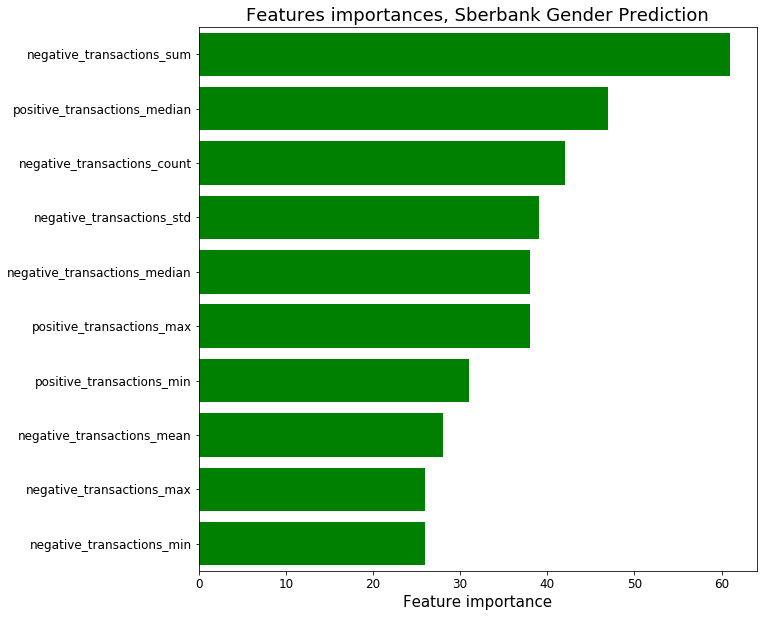

In [126]:
draw_feature_importances(clf, 10)

In [127]:
# Сохраняем результат моделирования

submission.to_csv('basic_features_submission.csv')

<font size=3>Видим, что результат на кросс-валидации = <font color='red'><b>62.2%</b></font> ROC AUC.

## Advanced features
Добавим дополнительные переменные по каждому пользователю в модель. <br>
Для этого будем анализировать дни недели, часы и состояние дня/ночи во время покупки - в каждом из случаев будем считать частоту транзакций в соответствующей категории относитеьно всех остальных категорий. <br>
То есть если, например, клиент в 70% случае совершал ночные траты, то мы получим вектор [0.7, 0.3] для этого случая в качестве частот транзакций ночью/днём.

In [141]:
for df in [transactions_train, transactions_test]:
    df['day'] = df['trans_time'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['trans_time'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['night'] = ~df['hour'].between(6, 22).astype(int)

In [182]:
def features_creation_advanced(x): 
    features = []
    features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['night'].value_counts(normalize=True).add_prefix('night_')))
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'sum'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'sum'])\
                                                        .add_prefix('negative_transactions_')))
    
    #added mcc
    #features.append(pd.Series(x['mcc_code'].value_counts(normalize=True).add_prefix('mcc_')))
    features.append(pd.Series(x['mcc_code'].value_counts(normalize=True)).add_prefix('mcc_'))
    
 
    return pd.concat(features)

In [184]:
data_train = transactions_train.groupby(transactions_train.index)\
                               .progress_apply(features_creation_advanced).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index)\
                             .progress_apply(features_creation_advanced).unstack(-1)

Progress:   0%|          | 0/7560 [00:00<?, ?it/s]

Progress:   0%|          | 0/840 [00:00<?, ?it/s]

In [185]:
data_out = data_train + data_test
print(data_out.shape)

(8400, 231)


In [191]:
data_test = data_out - data_train

In [192]:
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:51:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)
/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:51:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.873+-0.008, Trees: 190


In [193]:
df_out = data_train.combine_first(data_test)

In [194]:
# Число деревьев для XGBoost имеет смысл выятавлять по результатам на кросс-валидации 
clf, submission = fit_predict(params, 70, data_train, data_test, target)

/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:51:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


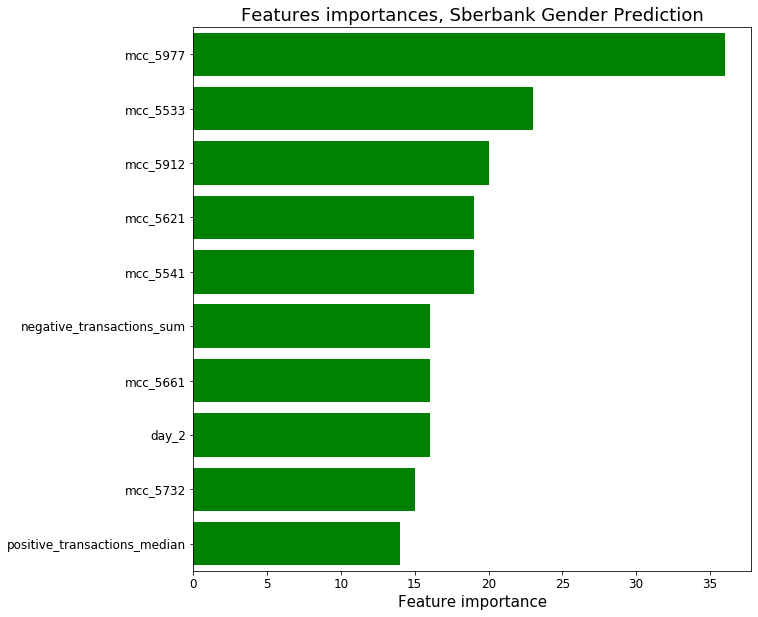

In [195]:
draw_feature_importances(clf, 10)

<font size=3>Добавление новых переменных улучшило наши результаты ROC AUC с <b>62.2%</b> до <font color='red'><b>68.4%</b></font>, на тестовой выборке результат будет аналогичным, так что мы явно не переобучились. При этом есть куда стремиться!

In [196]:
# Сохраняем результат моделирования

submission.to_csv('advanced_features_submission.csv')

### <font color='red'>Цель задания:
Полученная модель должна иметь ROC AUC на Public-части тестовой выборки (на лидерборде) <b>не менее 80%.

In [109]:
tr_mcc_codes = pd.read_csv(os.path.join(PATH_DATA, 'mcc_codes.csv'), sep=';', index_col='mcc_code')
tr_types = pd.read_csv(os.path.join(PATH_DATA, 'trans_types.csv'), sep=';', index_col='trans_type')

transactions = pd.read_csv(os.path.join(PATH_DATA, 'transactions.csv'), index_col='client_id')
gender_train = pd.read_csv(os.path.join(PATH_DATA, 'train.csv'), index_col='client_id')
gender_test = pd.read_csv(os.path.join(PATH_DATA, 'test.csv'), index_col='client_id')
transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')

#tr_mcc_codes = pd.read_csv('/kaggle/input/python-and-analyze-data-final-project/tr_mcc_codes.csv', sep=';', index_col='mcc_code')
#tr_types = pd.read_csv('/kaggle/input/python-and-analyze-data-final-project/tr_types.csv', sep=';', index_col='tr_type')
#transactions = pd.read_csv('/kaggle/input/python-and-analyze-data-final-project/transactions.csv', index_col='customer_id')
#gender_train = pd.read_csv('/kaggle/input/python-and-analyze-data-final-project/gender_train.csv', index_col='customer_id')
#gender_test = pd.read_csv('/kaggle/input/python-and-analyze-data-final-project/gender_test_kaggle_sample_submission.csv', index_col='customer_id')
#transactions_train = transactions.join(gender_train, how='inner')
#transactions_test = transactions.join(gender_test, how='inner')


In [110]:
for df in [transactions_train, transactions_test]:
    df['day'] = df['trans_time'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['trans_time'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['night'] = ~df['hour'].between(6, 22).astype(int)

transactions_train.head()

,trans_time,mcc_code,trans_type,amount,term_id,trans_city,Unnamed: 0,gender,day,hour,night
client_id,,,,,,,,,,,
0002cf30347684df542e1a931f356875,313 14:52:03,4829,2370,-2170.07,888990,Saint Petersburg,6806,0,5,14,-2
0002cf30347684df542e1a931f356875,150 14:10:49,6011,2010,-1445.64,NaN,Saint Petersburg,6806,0,3,14,-2
0002cf30347684df542e1a931f356875,122 12:38:32,5912,1010,-107.07,NaN,Saint Petersburg,6806,0,3,12,-2
0002cf30347684df542e1a931f356875,159 13:22:34,6011,2010,-2892.86,NaN,Saint Petersburg,6806,0,5,13,-2
0002cf30347684df542e1a931f356875,257 12:06:54,5912,1010,-164.49,469965,Saint Petersburg,6806,0,5,12,-2


In [112]:
tqdm_notebook.pandas(desc="Progress:")

def features_creation_advanced(x): 
    features = []
    features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['night'].value_counts(normalize=True).add_prefix('night_')))
    
    features.append(pd.Series(x[x['amount']>=0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'sum'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'sum'])\
                                                        .add_prefix('negative_transactions_')))

    features.append(pd.Series(x['mcc_code'].value_counts(normalize=True).add_prefix('mcc_')))
    
    return pd.concat(features)

In [113]:
data_train = transactions_train.groupby(transactions_train.index)\
                               .progress_apply(features_creation_advanced).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index)\
                             .progress_apply(features_creation_advanced).unstack(-1)

target = data_train.join(gender_train, how='inner')['gender']
target.value_counts()

Progress::   0%|          | 0/7560 [00:00<?, ?it/s]

Progress::   0%|          | 0/840 [00:00<?, ?it/s]

gender
0    4199
1    3361
Name: count, dtype: int64

In [197]:
X = data_train.copy()
y = target
test_df = data_test.copy()

X.fillna(-1, inplace=True)
test_df.fillna(-1, inplace=True)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
test_df = scaler.fit_transform(test_df)

X.shape, test_df.shape

((7560, 231), (8400, 231))

In [198]:
data_train

,day_0,day_1,day_2,day_3,day_4,day_5,day_6,hour_0,hour_1,hour_10,...,negative_transactions_sum,night_-1,night_-2,positive_transactions_count,positive_transactions_max,positive_transactions_mean,positive_transactions_median,positive_transactions_min,positive_transactions_std,positive_transactions_sum
client_id,,,,,,,,,,,,,,,,,,,,,
0002cf30347684df542e1a931f356875,0.208333,0.123016,0.053571,0.117063,0.125000,0.156746,0.216270,NaN,NaN,0.085317,...,-888203.30,0.013889,0.986111,32.0,42665.12,18450.900313,16450.650,722.09,14360.498086,590428.81
0002f4661e0d4d2ae097d78552dad022,0.146067,0.161049,0.104869,0.179775,0.153558,0.149813,0.104869,0.007491,NaN,0.071161,...,-74627.84,0.056180,0.943820,9.0,15909.56,2364.986667,723.370,312.99,5083.124389,21284.88
00081e0eca8ad94e493691f8f00099c6,0.178010,0.188482,0.057592,0.146597,0.162304,0.157068,0.109948,0.036649,NaN,0.057592,...,-62930.80,0.157068,0.842932,25.0,5423.80,1981.352400,1373.800,360.75,1704.496840,49533.81
0019bebcb5435df3103a5b0b52f5fc6b,0.146998,0.165631,0.121118,0.142857,0.136646,0.140787,0.145963,0.203934,0.007246,0.021739,...,-494382.45,0.435818,0.564182,301.0,20247.50,1032.745050,722.430,14.93,1743.349204,310856.26
001c8191ecac499718b33dc293a99e5b,0.160194,0.111650,0.082524,0.203883,0.169903,0.169903,0.101942,0.092233,NaN,0.024272,...,-232812.69,0.271845,0.728155,39.0,3616.52,1250.236923,723.710,145.62,950.703133,48759.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffe87ae84cf5d83af6a8a5de6dfe327f,0.217573,0.079498,0.061715,0.158996,0.141213,0.142259,0.198745,0.115063,NaN,0.046025,...,-1523362.06,0.246862,0.753138,231.0,36157.09,4291.427446,2965.470,11.70,4821.935240,991319.74
fff69a007a119605d6ff25c086840e7d,0.151862,0.157593,0.094556,0.128940,0.157593,0.166189,0.143266,0.094556,0.005731,0.048711,...,-205199.47,0.212034,0.787966,12.0,10847.20,3621.554167,3614.815,71.29,3664.842289,43458.65
fff78af489ca1024ba0ac7b3c2e47b60,0.165714,0.120000,0.085714,0.108571,0.160000,0.200000,0.160000,0.005714,NaN,0.080000,...,-313102.43,0.034286,0.965714,13.0,7231.79,4283.123077,3616.610,2168.91,1335.510188,55680.60


In [201]:
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
model_keras = Sequential()
model_keras.add(Dense(256, activation='sigmoid', input_dim=231))
model_keras.add(Dense(1024, activation='sigmoid'))
model_keras.add(Dense(128, activation='sigmoid'))
model_keras.add(Dense(1, activation='sigmoid'))

# Compile the model_keras
model_keras.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[tf.keras.metrics.AUC()])

In [202]:
model_keras.fit(X, y, epochs=50)

y_pred = model_keras.predict(test_df)

submission = pd.DataFrame(index=data_test.index)
submission['probability'] = y_pred
submission.to_csv('submission_kears.csv')
submission.head()

Epoch 1/50
237/237 [==============================] - 3s 7ms/step - loss: 0.6235 - auc_8: 0.6770
Epoch 2/50
237/237 [==============================] - 2s 7ms/step - loss: 0.4844 - auc_8: 0.8422
Epoch 3/50
237/237 [==============================] - 1s 6ms/step - loss: 0.4721 - auc_8: 0.8509
Epoch 4/50
237/237 [==============================] - 1s 6ms/step - loss: 0.4700 - auc_8: 0.8527
Epoch 5/50
237/237 [==============================] - 1s 6ms/step - loss: 0.4670 - auc_8: 0.8548
Epoch 6/50
237/237 [==============================] - 1s 6ms/step - loss: 0.4667 - auc_8: 0.8548
Epoch 7/50
237/237 [==============================] - 1s 6ms/step - loss: 0.4630 - auc_8: 0.8567
Epoch 8/50
237/237 [==============================] - 1s 6ms/step - loss: 0.4628 - auc_8: 0.8575
Epoch 9/50
237/237 [==============================] - 1s 6ms/step - loss: 0.4648 - auc_8: 0.8565
Epoch 10/50
237/237 [==============================] - 1s 5ms/step - loss: 0.4596 - auc_8: 0.8601
Epoch 11/50
237/237 [========

,probability
client_id,
0002cf30347684df542e1a931f356875,0.283507
0002f4661e0d4d2ae097d78552dad022,0.283507
00081e0eca8ad94e493691f8f00099c6,0.283507
0019bebcb5435df3103a5b0b52f5fc6b,0.283507
001c8191ecac499718b33dc293a99e5b,0.283507
